In [2]:
from datasets import load_dataset
import pandas as pd

In [3]:
#dataset1

# Load the dataset from Hugging Face Hub
train_dataset = load_dataset("kmack/Phishing_urls", split="train")
test_dataset = load_dataset("kmack/Phishing_urls", split="test")
valid_dataset = load_dataset("kmack/Phishing_urls", split="valid")

# Convert to pandas DataFrame
train_df = train_dataset.to_pandas()
test_df = test_dataset.to_pandas()
valid_df = valid_dataset.to_pandas()


all_df = [train_df, test_df,valid_df]
for i, df in enumerate(all_df):
    df['url'] = df['text']
    df.drop('text',axis=1,inplace=True)
print(train_df.head())

   label                                                url
0      0             xenophongroup.com/montjoie/compgns.htm
1      1    www.azzali.eu/&usg=AOvVaw2phVSb_ENMrkATGNx5LQ0l
2      1                     guildmusic.edu.au/js/index.htm
3      1  memo.unexpectedrunner.com/ezxgytw4et\nholotili...
4      0  en.wikipedia.org/wiki/Category:American_televi...


In [4]:
# Special tokens
special_tokens = ['<PAD>', '<UNK>', '<START>', '<END>']

# ASCII printable characters
ascii_chars = [chr(i) for i in range(32, 127)]  # ' ' (space) to '~'

# Full vocabulary
vocab = special_tokens + ascii_chars

# Create mappings
char2idx = {ch: idx for idx, ch in enumerate(vocab)}
idx2char = {idx: ch for ch, idx in char2idx.items()}
vocab_size = len(vocab)
print("Vocabulary size:", vocab_size)
print("Sample:", vocab[:50])


Vocabulary size: 99
Sample: ['<PAD>', '<UNK>', '<START>', '<END>', ' ', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '<', '=', '>', '?', '@', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M']


In [5]:
train_df = train_df.drop_duplicates(subset =['url'])

In [5]:
from tqdm import tqdm
import numpy as np
import torch
import torch.nn.functional as F
tqdm.pandas()

max_url_length = 50


def encode_url(url):
    indices = torch.tensor([0]*max_url_length)
    for i,c in enumerate(url[:max_url_length]):
        indices[i] = char2idx.get(c, char2idx['<UNK>'])
    #print(indices)  


    return indices

# Apply encoding to your URL column
train_df['encode'] = train_df['url'].progress_apply(encode_url)
test_df['encode'] = test_df['url'].progress_apply(encode_url)
valid_df['encode'] = valid_df['url'].progress_apply(encode_url)



100%|██████████| 535838/535838 [01:11<00:00, 7465.04it/s]
C:\Users\rrpra\AppData\Local\Temp\ipykernel_23060\3970848146.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['encode'] = train_df['url'].progress_apply(encode_url)
100%|██████████| 70882/70882 [00:09<00:00, 7586.71it/s]


In [6]:
import torch
from torch.utils.data import TensorDataset, DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Convert encoded URLs to proper tensors
url_tensor = torch.tensor(np.stack(train_df['encode'].values), dtype=torch.long)
labels_tensor = torch.tensor(train_df['label'].values, dtype=torch.long)

valid_url_tensor = torch.tensor(np.stack(valid_df['encode'].values), dtype=torch.long)
valid_labels_tensor = torch.tensor(valid_df['label'].values, dtype=torch.long)

test_url_tensor = torch.tensor(np.stack(test_df['encode'].values), dtype=torch.long)
test_labels_tensor = torch.tensor(test_df['label'].values, dtype=torch.long)


train_dataset = TensorDataset(url_tensor, labels_tensor)
train_loader = DataLoader(train_dataset, batch_size=4056, shuffle=True)

val_dataset = TensorDataset(valid_url_tensor, valid_labels_tensor)
val_loader = DataLoader(val_dataset, batch_size=4056, shuffle=False)

test_dataset = TensorDataset(test_url_tensor, test_labels_tensor)
test_loader = DataLoader(test_dataset, batch_size=4056, shuffle=False)


In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class URLBinaryCNN(nn.Module):
    def __init__(self, vocab_size, embed_dim=128, maxlen=200):
        super(URLBinaryCNN, self).__init__()

        # 🔹 Embedding layer
        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embed_dim)

        # 🔹 1st Conv block
        self.conv1 = nn.Conv1d(in_channels=embed_dim, out_channels=256, kernel_size=5, padding=2)
        self.bn1 = nn.BatchNorm1d(256)
        self.pool1 = nn.MaxPool1d(kernel_size=2)

        # 🔹 2nd Conv block
        self.conv2 = nn.Conv1d(in_channels=256, out_channels=128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm1d(128)
        self.pool2 = nn.MaxPool1d(kernel_size=2)

        # 🔹 3rd Conv block
        self.conv3 = nn.Conv1d(in_channels=128, out_channels=64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm1d(64)

        # 🔹 Global Max Pooling
        self.global_pool = nn.AdaptiveMaxPool1d(1)

        # 🔹 Fully connected layers
        self.fc1 = nn.Linear(64, 128)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 64)
        self.dropout2 = nn.Dropout(0.3)
        self.fc3 = nn.Linear(64, 1)

    def forward(self, x):
        # x shape: (batch_size, seq_len)
        x = self.embedding(x)  # (batch_size, seq_len, embed_dim)
        x = x.permute(0, 2, 1)  # (batch_size, embed_dim, seq_len) for Conv1D

        # Conv block 1
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool1(x)

        # Conv block 2
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool2(x)

        # Conv block 3
        x = F.relu(self.bn3(self.conv3(x)))

        # Global max pooling
        x = self.global_pool(x)
        x = x.squeeze(-1)  # (batch_size, out_channels)

        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)  # sigmoid for binary output

        return x



In [44]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [20]:
from tqdm import tqdm
import sys
import torch
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = URLBinaryCNN(vocab_size=len(vocab)).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10

# === Lists to store metrics ===
cnn_train_losses = []
cnn_val_losses = []
cnn_train_accuracies = []
cnn_val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    correct_train = 0
    total_train = 0
    
    for batch_idx, (batch_x, batch_y) in enumerate(train_loader):
        batch_x, batch_y = batch_x.to(device), batch_y.to(device).float().unsqueeze(1)
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        
        # --- Batch metrics ---
        batch_loss = loss.item()
        preds = (torch.sigmoid(outputs) >= 0.5).float()
        batch_acc = (preds == batch_y).float().mean().item()
        
        # Update running totals
        train_loss += batch_loss * batch_x.size(0)
        correct_train += (preds == batch_y).sum().item()
        total_train += batch_x.size(0)
        
        # Print batch metrics on the same line
        sys.stdout.write(f"\rEpoch {epoch+1}/{num_epochs} | "
                         f"Batch {batch_idx+1}/{len(train_loader)} | "
                         f"Batch Loss: {batch_loss:.4f}, Batch Acc: {batch_acc:.4f}")
        sys.stdout.flush()
    
    train_acc = correct_train / total_train
    avg_train_loss = train_loss / total_train
    print()  # Move to next line after finishing epoch

    # --- Validation ---
    model.eval()
    val_loss = 0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for batch_x, batch_y in val_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device).float().unsqueeze(1)
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            
            val_loss += loss.item() * batch_x.size(0)
            preds = (torch.sigmoid(outputs) >= 0.5).float()
            correct_val += (preds == batch_y).sum().item()
            total_val += batch_x.size(0)
    
    val_acc = correct_val / total_val
    avg_val_loss = val_loss / total_val

    # === Store metrics ===
    cnn_train_losses.append(avg_train_loss)
    cnn_val_losses.append(avg_val_loss)
    cnn_train_accuracies.append(train_acc)
    cnn_val_accuracies.append(val_acc)
    
    # Print epoch summary
    print(f"Epoch {epoch+1}/{num_epochs} | "
          f"Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.4f} | "
          f"Val Loss: {avg_val_loss:.4f}, Val Acc: {val_acc:.4f}")


Epoch 1/10 | Batch 133/133 | Batch Loss: 0.2681, Batch Acc: 0.8812
Epoch 1/10 | Train Loss: 0.3347, Train Acc: 0.8567 | Val Loss: 0.3012, Val Acc: 0.8707
Epoch 2/10 | Batch 133/133 | Batch Loss: 0.2402, Batch Acc: 0.9081
Epoch 2/10 | Train Loss: 0.2510, Train Acc: 0.8976 | Val Loss: 0.2978, Val Acc: 0.8706
Epoch 3/10 | Batch 133/133 | Batch Loss: 0.2660, Batch Acc: 0.8789
Epoch 3/10 | Train Loss: 0.2305, Train Acc: 0.9056 | Val Loss: 0.2827, Val Acc: 0.8761
Epoch 4/10 | Batch 133/133 | Batch Loss: 0.2080, Batch Acc: 0.9058
Epoch 4/10 | Train Loss: 0.2171, Train Acc: 0.9108 | Val Loss: 0.2799, Val Acc: 0.8800
Epoch 5/10 | Batch 133/133 | Batch Loss: 0.2241, Batch Acc: 0.9148
Epoch 5/10 | Train Loss: 0.2047, Train Acc: 0.9151 | Val Loss: 0.3082, Val Acc: 0.8724
Epoch 6/10 | Batch 133/133 | Batch Loss: 0.1880, Batch Acc: 0.9103
Epoch 6/10 | Train Loss: 0.1965, Train Acc: 0.9183 | Val Loss: 0.2841, Val Acc: 0.8810
Epoch 7/10 | Batch 133/133 | Batch Loss: 0.1956, Batch Acc: 0.9305
Epoch 7/1

In [46]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import torch


In [47]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for i in range(0, len(test_url_tensor), 64):  # batch size 64
        batch_x = test_url_tensor[i:i+64].to(device)
        batch_y = test_labels_tensor[i:i+64].to(device)
        
        outputs = model(batch_x)
        preds = (outputs >= 0.5).long().squeeze(1)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(batch_y.cpu().numpy())


Confusion Matrix:
 [[30459  4780]
 [ 4111 31532]]


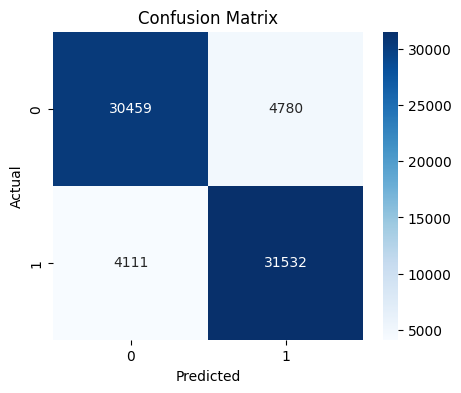

              precision    recall  f1-score   support

        Safe       0.88      0.86      0.87     35239
    Phishing       0.87      0.88      0.88     35643

    accuracy                           0.87     70882
   macro avg       0.87      0.87      0.87     70882
weighted avg       0.87      0.87      0.87     70882



In [48]:
cm = confusion_matrix(all_labels, all_preds)
print("Confusion Matrix:\n", cm)

# Optional: pretty plot
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
print(classification_report(all_labels, all_preds, target_names=['Safe', 'Phishing']))


### 🧮 Accuracy for char based models (CNN)

> **Accuracy:** `0.50`

| Class | Precision | Recall | F1-Score | Support |
|:------|:-----------|:--------|:----------|:----------|
| **0** | 0.00 | 0.00 | 0.00 | 35239 |
| **1** | 0.50 | 1.00 | 0.67 | 35643 |
| **Accuracy** |  |  | **0.50** | 70882 |
| **Macro Avg** | 0.25 | 0.50 | 0.33 | 70882 |
| **Weighted Avg** | 0.25 | 0.50 | 0.34 | 70882 |

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNN_BiLSTM(nn.Module):
    def __init__(self, vocab_size, embed_dim=128):
        super(CNN_BiLSTM, self).__init__()
        
        # Embedding layer
        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embed_dim)
        
        # Conv blocks
        self.conv1 = nn.Conv1d(embed_dim, 256, kernel_size=8, padding=4)
        self.pool1 = nn.MaxPool1d(2)

        self.conv2 = nn.Conv1d(256, 128, kernel_size=5, padding=2)
        self.pool2 = nn.MaxPool1d(2)
        
        # BiLSTM
        self.lstm = nn.LSTM(input_size=128, hidden_size=64, num_layers=1,
                            batch_first=True, bidirectional=True)
        
        # Fully connected layers
        self.fc1 = nn.Linear(64*2, 128)  # 64*2 because bidirectional
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 1)  # binary output
        
    def forward(self, x):
        # x: (batch_size, seq_len)
        x = self.embedding(x)  # (batch_size, seq_len, embed_dim)
        x = x.permute(0, 2, 1)  # (batch_size, embed_dim, seq_len) for Conv1d
        
        # Conv block 1
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        
        # Conv block 2
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        
        # Prepare for LSTM: (batch_size, seq_len, features)
        x = x.permute(0, 2, 1)
        
        # BiLSTM
        lstm_out, _ = self.lstm(x)  # lstm_out: (batch_size, seq_len, 2*hidden_size)
        
        # Take the last timestep
        x = lstm_out[:, -1, :]  # (batch_size, 128)
        
        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = self.fc2(x)
        
        return x


In [18]:
from tqdm import tqdm
import sys
import torch
import torch.nn.functional as F
import torch.nn as nn
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = CNN_BiLSTM(vocab_size=len(vocab)).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10

# For tracking metrics
bi_lstm_train_losses, bi_lstm_val_losses = [], []
bi_lstm_train_accuracies, bi_lstm_val_accuracies = [], []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    correct_train = 0
    total_train = 0
    
    for batch_idx, (batch_x, batch_y) in enumerate(train_loader):
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device).float().unsqueeze(1)
        batch_y = torch.clamp(batch_y, 0, 1)

        optimizer.zero_grad()
        outputs = model(batch_x)

        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        
        # Batch metrics
        batch_loss = loss.item()
        preds = (torch.sigmoid(outputs) >= 0.5).float()
        batch_acc = (preds == batch_y).float().mean().item()
        
        # Update totals
        train_loss += batch_loss * batch_x.size(0)
        correct_train += (preds == batch_y).sum().item()
        total_train += batch_x.size(0)
        
        sys.stdout.write(f"\rEpoch {epoch+1}/{num_epochs} | "
                         f"Batch {batch_idx+1}/{len(train_loader)} | "
                         f"Batch Loss: {batch_loss:.4f}, Batch Acc: {batch_acc:.4f}")
        sys.stdout.flush()
    
    train_acc = correct_train / total_train
    train_loss = train_loss / total_train
    print()  # newline
    
    # --- Validation ---
    model.eval()
    val_loss = 0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for batch_x, batch_y in val_loader:
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device).float().unsqueeze(1)
            batch_y = torch.clamp(batch_y, 0, 1)

            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            
            val_loss += loss.item() * batch_x.size(0)
            preds = (torch.sigmoid(outputs) >= 0.5).float()
            correct_val += (preds == batch_y).sum().item()
            total_val += batch_x.size(0)
    
    val_acc = correct_val / total_val
    val_loss = val_loss / total_val

    # Save metrics for plotting
    bi_lstm_train_losses.append(train_loss)
    bi_lstm_val_losses.append(val_loss)
    bi_lstm_train_accuracies.append(train_acc)
    bi_lstm_val_accuracies.append(val_acc)
    
    print(f"Epoch {epoch+1}/{num_epochs} | "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")



Epoch 1/10 | Batch 133/133 | Batch Loss: 0.3565, Batch Acc: 0.8565
Epoch 1/10 | Train Loss: 0.4195, Train Acc: 0.8039 | Val Loss: 0.3549, Val Acc: 0.8504
Epoch 2/10 | Batch 133/133 | Batch Loss: 0.2645, Batch Acc: 0.8834
Epoch 2/10 | Train Loss: 0.2795, Train Acc: 0.8858 | Val Loss: 0.3028, Val Acc: 0.8719
Epoch 3/10 | Batch 133/133 | Batch Loss: 0.2406, Batch Acc: 0.9013
Epoch 3/10 | Train Loss: 0.2469, Train Acc: 0.8993 | Val Loss: 0.3071, Val Acc: 0.8651
Epoch 4/10 | Batch 133/133 | Batch Loss: 0.2278, Batch Acc: 0.9103
Epoch 4/10 | Train Loss: 0.2292, Train Acc: 0.9057 | Val Loss: 0.2762, Val Acc: 0.8796
Epoch 5/10 | Batch 133/133 | Batch Loss: 0.2590, Batch Acc: 0.8879
Epoch 5/10 | Train Loss: 0.2154, Train Acc: 0.9108 | Val Loss: 0.2676, Val Acc: 0.8817
Epoch 6/10 | Batch 133/133 | Batch Loss: 0.2388, Batch Acc: 0.8722
Epoch 6/10 | Train Loss: 0.2038, Train Acc: 0.9152 | Val Loss: 0.2641, Val Acc: 0.8833
Epoch 7/10 | Batch 133/133 | Batch Loss: 0.2261, Batch Acc: 0.8991
Epoch 7/1

In [21]:
import plotly.graph_objects as go

# === 📈 Plot Loss ===
num_epochs = len(bi_lstm_train_losses)  # auto-adjust
epochs = list(range(1, num_epochs + 1))

fig = go.Figure()

# --- BiLSTM losses (blue tones) ---
fig.add_trace(go.Scatter(
    x=epochs, y=bi_lstm_train_losses,
    mode='lines+markers',
    name='BiLSTM Train Loss',
    line=dict(color='royalblue', width=2),
    marker=dict(color='royalblue')
))
fig.add_trace(go.Scatter(
    x=epochs, y=bi_lstm_val_losses,
    mode='lines+markers',
    name='BiLSTM Validation Loss',
    line=dict(color='lightblue', width=2, dash='dash'),
    marker=dict(color='lightblue')
))

# --- CNN losses (orange/red tones) ---
fig.add_trace(go.Scatter(
    x=epochs, y=cnn_train_losses,
    mode='lines+markers',
    name='CNN Train Loss',
    line=dict(color='darkorange', width=2),
    marker=dict(color='darkorange')
))
fig.add_trace(go.Scatter(
    x=epochs, y=cnn_val_losses,
    mode='lines+markers',
    name='CNN Validation Loss',
    line=dict(color='tomato', width=2, dash='dash'),
    marker=dict(color='tomato')
))

# Layout
fig.update_layout(
    title='📉 Training vs Validation Loss (BiLSTM vs CNN)',
    xaxis_title='Epoch',
    yaxis_title='Loss',
    legend_title='Legend',
    template='plotly_white',
    title_font=dict(size=20, family='Arial'),
    xaxis=dict(showgrid=True),
    yaxis=dict(showgrid=True)
)

fig.show()

# === 📊 Plot Accuracy ===
fig2 = go.Figure()

# --- BiLSTM accuracies (blue tones) ---
fig2.add_trace(go.Scatter(
    x=epochs, y=bi_lstm_train_accuracies,
    mode='lines+markers',
    name='BiLSTM Train Accuracy',
    line=dict(color='royalblue', width=2),
    marker=dict(color='royalblue')
))
fig2.add_trace(go.Scatter(
    x=epochs, y=bi_lstm_val_accuracies,
    mode='lines+markers',
    name='BiLSTM Validation Accuracy',
    line=dict(color='lightblue', width=2, dash='dash'),
    marker=dict(color='lightblue')
))

# --- CNN accuracies (orange/red tones) ---
fig2.add_trace(go.Scatter(
    x=epochs, y=cnn_train_accuracies,
    mode='lines+markers',
    name='CNN Train Accuracy',
    line=dict(color='darkorange', width=2),
    marker=dict(color='darkorange')
))
fig2.add_trace(go.Scatter(
    x=epochs, y=cnn_val_accuracies,
    mode='lines+markers',
    name='CNN Validation Accuracy',
    line=dict(color='tomato', width=2, dash='dash'),
    marker=dict(color='tomato')
))

# Layout
fig2.update_layout(
    title='✅ Training vs Validation Accuracy (BiLSTM vs CNN)',
    xaxis_title='Epoch',
    yaxis_title='Accuracy',
    legend_title='Legend',
    template='plotly_white',
    title_font=dict(size=20, family='Arial'),
    xaxis=dict(showgrid=True),
    yaxis=dict(showgrid=True)
)

fig2.show()


In [22]:
from transformers import BertTokenizer, BertModel
import torch
from tqdm import tqdm


c:\Users\rrpra\AppData\Local\Programs\Python\Python313\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning:

Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/attr_value.proto. Please update the gencode to avoid compatibility violations in the next runtime release.

c:\Users\rrpra\AppData\Local\Programs\Python\Python313\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning:

Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/tensor.proto. Please update the gencode to avoid compatibility violations in the next runtime release.

c:\Users\rrpra\AppData\Local\Programs\Python\Python313\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning:

Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/resource_handle.proto. Ple

In [23]:
# Load BERT base model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert = BertModel.from_pretrained('bert-base-uncased')

# Set model to evaluation mode (no gradients needed)
bert.eval()


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

c:\Users\rrpra\AppData\Local\Programs\Python\Python313\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning:

`huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\rrpra\.cache\huggingface\hub\models--bert-base-uncased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development



vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [ ]:
import torch
from torch.utils.data import TensorDataset, DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Convert encoded URLs to proper tensors
url_tensor = torch.tensor(np.stack(train_df['encode'].values), dtype=torch.long)
labels_tensor = torch.tensor(train_df['label'].values, dtype=torch.long)

valid_url_tensor = torch.tensor(np.stack(valid_df['encode'].values), dtype=torch.long)
valid_labels_tensor = torch.tensor(valid_df['label'].values, dtype=torch.long)

test_url_tensor = torch.tensor(np.stack(test_df['encode'].values), dtype=torch.long)
test_labels_tensor = torch.tensor(test_df['label'].values, dtype=torch.long)


train_dataset = TensorDataset(url_tensor, labels_tensor)
train_loader = DataLoader(train_dataset, batch_size=4056, shuffle=True)

val_dataset = TensorDataset(valid_url_tensor, valid_labels_tensor)
val_loader = DataLoader(val_dataset, batch_size=4056, shuffle=False)

test_dataset = TensorDataset(test_url_tensor, test_labels_tensor)
test_loader = DataLoader(test_dataset, batch_size=4056, shuffle=False)


In [8]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer

# Initialize BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
MAX_LEN = 50  # max token length

class URLDataset(Dataset):
    def __init__(self, df, tokenizer, max_len=MAX_LEN):
        self.urls = df['url'].values
        self.labels = df['label'].values
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.urls)

    def __getitem__(self, idx):
        url = str(self.urls[idx])
        label = int(self.labels[idx])

        enc = self.tokenizer(
            url,
            truncation=True,
            padding='max_length',
            max_length=self.max_len,
            return_tensors='pt'
        )

        return {
            'input_ids': enc['input_ids'].squeeze(0),
            'attention_mask': enc['attention_mask'].squeeze(0),
            'label': torch.tensor(label, dtype=torch.float)
        }


In [ ]:
BATCH_SIZE = 512

train_data = URLDataset(train_df, tokenizer)
valid_data = URLDataset(valid_df, tokenizer)
test_data = URLDataset(test_df, tokenizer)

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)


In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import BertTokenizer, BertModel

class CNN_BiLSTM_bert_fast(nn.Module):
    def __init__(self, freeze_bert=True):
        super(CNN_BiLSTM_bert_fast, self).__init__()

        # === Load pretrained BERT ===
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False

        # === Single CNN layer with fewer channels ===
        self.conv1 = nn.Conv1d(in_channels=768, out_channels=64, kernel_size=5, padding=2)
        self.pool1 = nn.MaxPool1d(kernel_size=4, stride=4)  # bigger pooling → reduces seq length faster

        # === BiLSTM with smaller hidden size ===
        self.lstm = nn.LSTM(input_size=64, hidden_size=32, num_layers=1,
                            batch_first=True, bidirectional=True)

        # === Fully Connected with smaller dense layer ===
        self.fc1 = nn.Linear(32 * 2, 32)  # bidirectional → 32*2
        self.dropout = nn.Dropout(0.3)
        self.fc2 = nn.Linear(32, 1)  # binary output

    def forward(self, input_ids, attention_mask):
        # === Step 1: BERT embeddings ===
        with torch.no_grad():  # freeze BERT for speed
            outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
            x = outputs.last_hidden_state  # (batch, seq_len, 768)

        # === Step 2: CNN layer ===
        x = x.permute(0, 2, 1)  # (batch, 768, seq_len)
        x = F.relu(self.conv1(x))
        x = self.pool1(x)  # reduces sequence length by factor of 4

        # === Step 3: BiLSTM ===
        x = x.permute(0, 2, 1)  # (batch, seq_len', features)
        lstm_out, _ = self.lstm(x)
        x = lstm_out[:, -1, :]  # last timestep

        # === Step 4: Classification ===
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)

        return x


In [18]:
from tqdm import tqdm
import sys
import torch
import torch.nn.functional as F
import torch.nn as nn
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = CNN_BiLSTM_bert_fast(freeze_bert=True).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 5

# For tracking metrics
bert_lstm_train_losses, bert_lstm_val_losses = [], []
bert_lstm_train_accuracies, bert_lstm_val_accuracies = [], []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    correct_train = 0
    total_train = 0
    
    for batch_idx, batch in enumerate(train_loader):
        batch_x = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        batch_y = batch['label'].to(device).float().unsqueeze(1)
        batch_y = torch.clamp(batch_y, 0, 1)

        optimizer.zero_grad()
        outputs = model(batch_x, attention_mask)

        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        
        # Batch metrics
        batch_loss = loss.item()
        preds = (torch.sigmoid(outputs) >= 0.5).float()
        batch_acc = (preds == batch_y).float().mean().item()
        
        # Update totals
        train_loss += batch_loss * batch_x.size(0)
        correct_train += (preds == batch_y).sum().item()
        total_train += batch_x.size(0)
        
        sys.stdout.write(f"\rEpoch {epoch+1}/{num_epochs} | "
                         f"Batch {batch_idx+1}/{len(train_loader)} | "
                         f"Batch Loss: {batch_loss:.4f}, Batch Acc: {batch_acc:.4f}")
        sys.stdout.flush()
    
    train_acc = correct_train / total_train
    train_loss = train_loss / total_train
    print()  # newline
    
    # --- Validation ---
    model.eval()
    val_loss = 0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for batch_idx, batch in enumerate(val_loader):
            batch_x = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            batch_y = batch['label'].to(device).float().unsqueeze(1)
            batch_y = torch.clamp(batch_y, 0, 1)

            outputs = model(batch_x, attention_mask)
            loss = criterion(outputs, batch_y)
            
            val_loss += loss.item() * batch_x.size(0)
            preds = (torch.sigmoid(outputs) >= 0.5).float()
            correct_val += (preds == batch_y).sum().item()
            total_val += batch_x.size(0)
    
    val_acc = correct_val / total_val
    val_loss = val_loss / total_val

    # Save metrics for plotting
    bert_lstm_train_losses.append(train_loss)
    bert_lstm_val_losses.append(val_loss)
    bert_lstm_train_accuracies.append(train_acc)
    bert_lstm_val_accuracies.append(val_acc)
    
    print(f"Epoch {epoch+1}/{num_epochs} | "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")



Epoch 1/5 | Batch 45/262 | Batch Loss: 0.3945, Batch Acc: 0.8423

KeyboardInterrupt: 